In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [2]:
# Load the VGG16 model
model_path = '../models/vgg16_model.keras'
model = tf.keras.models.load_model(model_path)

C:\Users\adity\Desktop\Code\Python\DiabeticRetinopathy\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
# Isolate the layers that Grad-CAM can utilise
conv_layer_name_list = []
for layer in model.layers:
    conv_layer_name_list.append(layer.name)
del conv_layer_name_list[0]
del conv_layer_name_list[18:]

In [6]:
# Function to preprocess the input image
def preprocess_image(img_path):
    # img = image.load_img(img_path, target_size=(224, 224))
    # img_array = image.img_to_array(img)
    # img_array = np.expand_dims(img_array, axis=0)
    # # img_array = preprocess_input(img_array)
    # return img_array
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

In [7]:
# Function to generate Grad-CAM heatmap
def get_grad_cam_heatmap(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

In [8]:
# Function to overlay heatmap on original image
def overlay_heatmap_on_image(img_path, heatmap, intensity=0.5, colormap=cv2.COLORMAP_JET):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed_img = cv2.addWeighted(img, 1 - intensity, heatmap, intensity, 0)
    return overlayed_img

In [9]:
# Load and preprocess the images
# Mild
mild_path = '../archive/gaussian_filtered_images/Mild/0024cdab0c1e.png'

# Moderate
moderate_path = '../archive/gaussian_filtered_images/Moderate/000c1434d8d7.png'

# No_DR
# no_dr_path = '../archive/gaussian_filtered_images/No_DR/002c21358ce6.png'
no_dr_path = '../archive/gaussian_filtered_images/No_DR/05b1bb2bdb81.png'

# Proliferate_DR
# prof_dr_path = '../archive/gaussian_filtered_images/Proliferate_DR/001639a390f0.png'
prof_dr_path = '../archive/gaussian_filtered_images/Proliferate_DR/02dda30d3acf.png'

# Severe
severe_path = '../archive/gaussian_filtered_images/Severe/0104b032c141.png'

In [10]:
def layer_image_grad_cam(img_array, img_path):
    layer_image_list = []
    for layer in conv_layer_name_list:
        # Generate Grad-CAM heatmap
        heatmap = get_grad_cam_heatmap(model, img_array, layer_name=layer)
        
        # Overlay heatmap on original image
        overlayed_img = overlay_heatmap_on_image(img_path, heatmap)
        layer_image_list.append(overlayed_img)
    return layer_image_list

In [11]:
def display_grad_cam(layer_image_list, conv_layer_name_list, rows, cols):
    
    # Create a figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Plot each image in the corresponding subplot
    for i in range(len(layer_image_list)):
        ax = axes[i]
        ax.imshow(cv2.cvtColor(layer_image_list[i], cv2.COLOR_BGR2RGB))
        ax.set_title(conv_layer_name_list[i])
        ax.axis('off')  # Hide axes
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [12]:
def visualise_layer_outputs(img_path, conv_layer_name_list, rows, cols):
    img_array = preprocess_image(img_path)
    layer_image_list = layer_image_grad_cam(img_array, img_path)
    display_grad_cam(layer_image_list, conv_layer_name_list, rows, cols)

NO DR


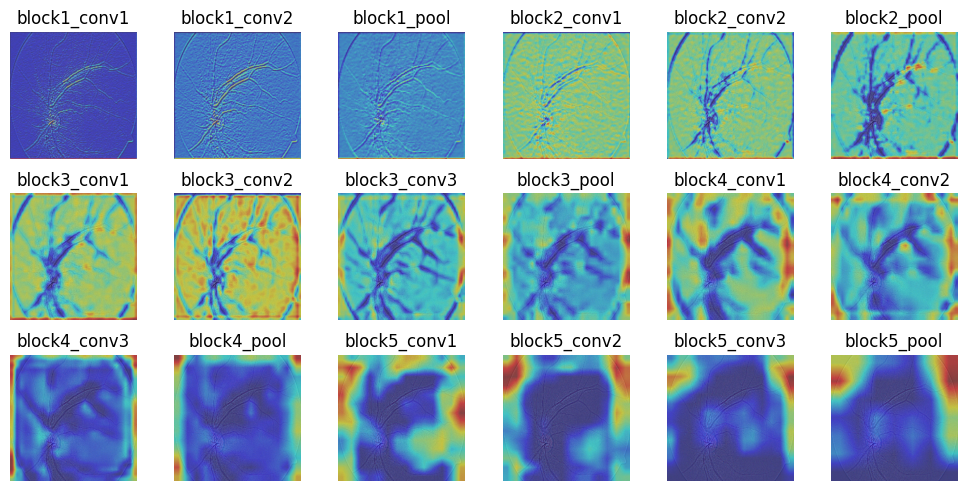

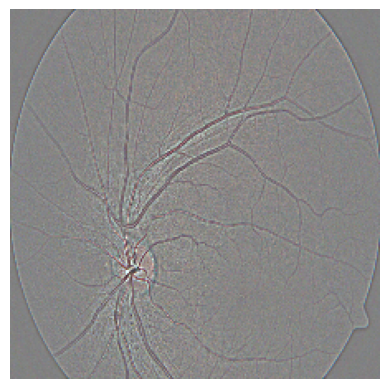

In [13]:
# Visualising No DR Case
print("NO DR")
visualise_layer_outputs(no_dr_path, conv_layer_name_list, 3, 6)
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread(no_dr_path), cv2.COLOR_BGR2RGB))

MILD


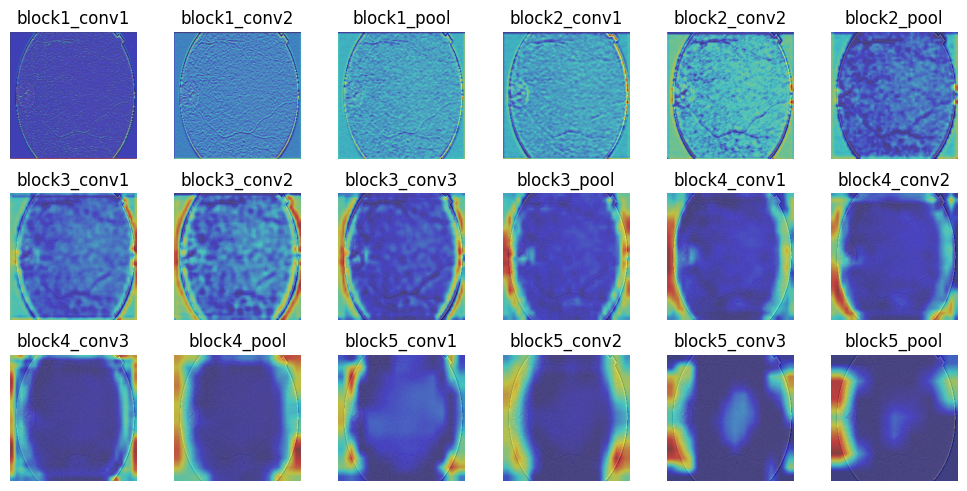

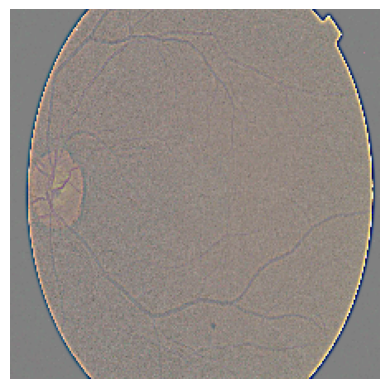

In [14]:
# Visualising Mild Case
print("MILD")
visualise_layer_outputs(mild_path, conv_layer_name_list, 3, 6)
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread(mild_path), cv2.COLOR_BGR2RGB))

MODERATE


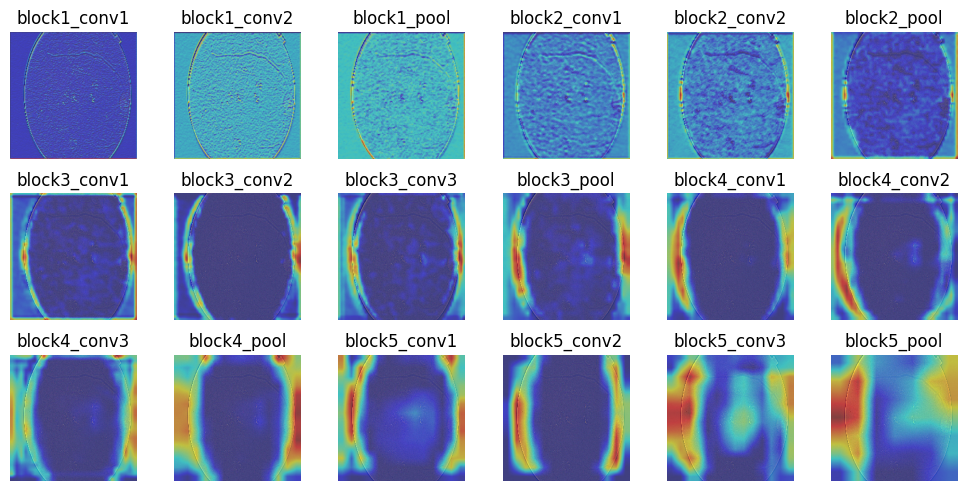

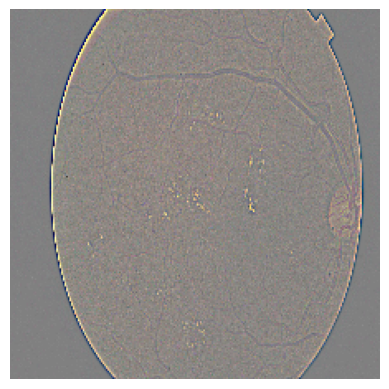

In [15]:
# Visualising Moderate Case
print("MODERATE")
visualise_layer_outputs(moderate_path, conv_layer_name_list, 3, 6)
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread(moderate_path), cv2.COLOR_BGR2RGB))

PROLIFERATE DR


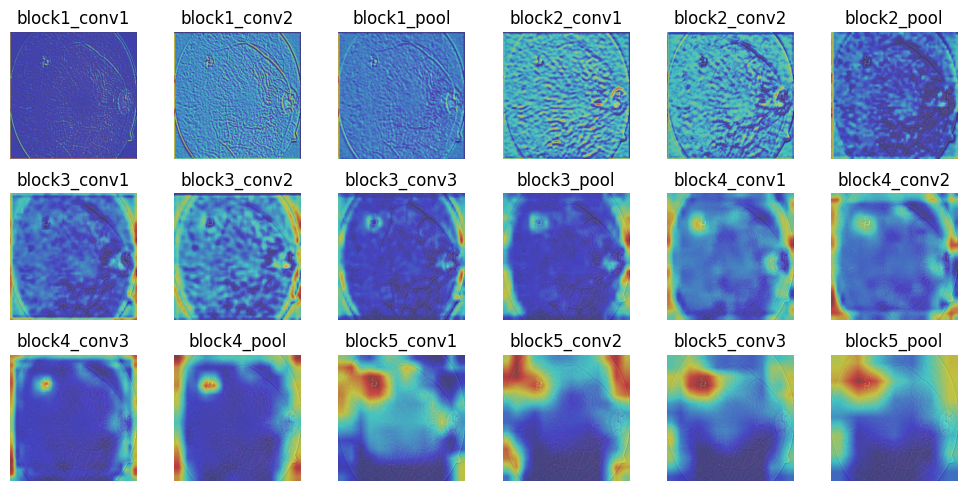

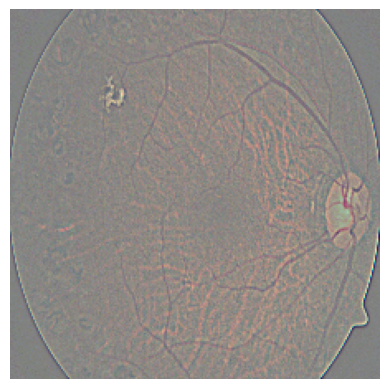

In [16]:
# Visualising Proliferate DR Case
print("PROLIFERATE DR")
visualise_layer_outputs(prof_dr_path, conv_layer_name_list, 3, 6)
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread(prof_dr_path), cv2.COLOR_BGR2RGB))

SEVERE


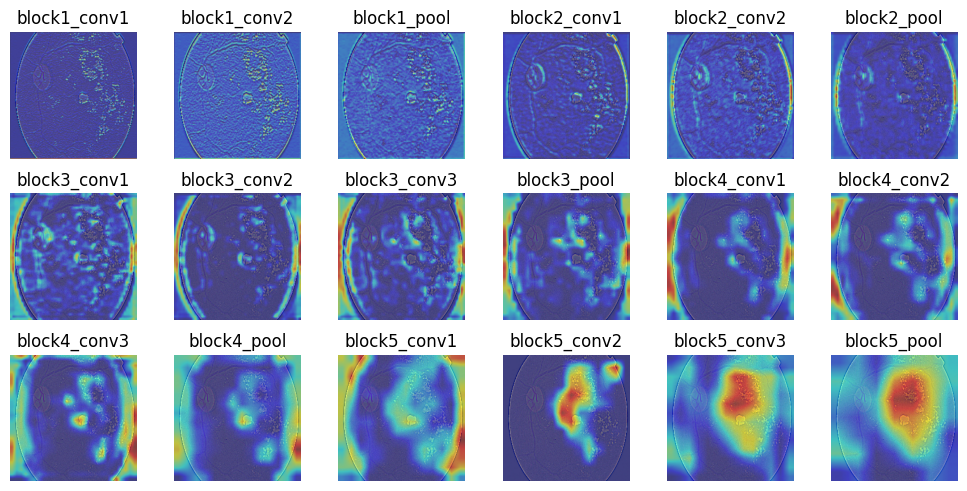

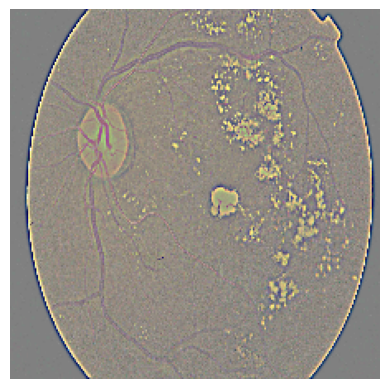

In [17]:
# Visualising Severe Case
print("SEVERE")
visualise_layer_outputs(severe_path, conv_layer_name_list, 3, 6)
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread(severe_path), cv2.COLOR_BGR2RGB))